In [41]:
import numpy as np
import numpy.linalg as LA
import math
import matplotlib.pyplot as plt
import scipy.stats as s_stats

from scipy.optimize import curve_fit
from scipy.optimize import brute
from scipy import asarray as ar,exp

import scipy.special as sp

from scipy.integrate import quad
from scipy.integrate import romberg

from tkinter import Tk
from tkinter import filedialog as fd

#other methods to explore:
#bayesian blocks (variable bin widths), implemented in astropy
#kernel density estimation (implemented in scipy)

In [42]:
#return a bool indicating if a string can be represented numerically
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [43]:
#as an assessment of fit goodness, calculate the Bayesian Information Criterion (BIC)
#parameters are the Residual Sum of Squares RSS, number of model parameters k, and number of data points n
def calculate_BIC(RSS,k,n):
    return n*math.log(RSS/n)+k*math.log(n)

In [44]:
#read in the mobility file
root = Tk()
filename = fd.askopenfilename(title = "Choose the mobility file")
f = open(filename,'r')
root.withdraw()

resistanceList = []
for line in f:
    newline = line.split()
    if is_number(newline[0][0]):
        resistanceList.append([float(newline[1]),float(newline[2])])  

In [45]:
#Try to normalize the data logarithmically via a Box-Cox Normality Transform
#The transform is T(y)=(y^lambda-1)/lambda if lambda!=0, T(y)=log(y) if lambda=0
#The efficacy of the transform is assessed by measuring the normality of the resulting distribution
#This is done by using the scipy.stats.pearsonr method for measuring the pearson coefficient, on the
#corresponding normal probability plot

def applyBoxCoxTransform(resistanceList):
    mobilityList = [i[0] for i in resistanceList if i[0] > 0.0]
    
    #plot the default data
    count, bins = np.histogram(mobilityList, 'fd')
    centers = [(i + bins[n])/2 for n, i in enumerate(bins[1:])]
    plt.hist(mobilityList,bins = len(centers))
    plt.ylabel("Count")
    plt.xlabel("Mobility")
    plt.title('Raw Data')
    plt.show()
    
    
    cList = []
    _lambda = -0.5
    lambda_array = []
    lambdaMax = _lambda
    maxR = 0
    while _lambda < 1.0:
        if not np.isclose(_lambda, 0.0):
            T_of_mu = np.asarray([(i**_lambda-1)/_lambda for i in mobilityList])
        else:
            T_of_mu = np.asarray([math.log(i) for i in mobilityList])
        #n_bins = 60
        #use the freedman-diaconis rule to calculate number of bins
        #Under FD: h = 2*IQR*(n^(-1/3))
        hist, bins = np.histogram(T_of_mu, 'fd')
        centers = [(i + bins[n])/2 for n, i in enumerate(bins[1:])]

        #r_row, p_value = s_stats.pearsonr(hist, centers)

        #create the normal probability plot
        result = s_stats.probplot(T_of_mu)
        (osm,osr) = result[0]
        (slope,intercept,r) = result[1]

        r_row, p_values = s_stats.pearsonr(osm,osr)
        cList.append(r_row)

        if r_row > maxR:
            maxR = r_row
            lambdaMax = _lambda
            storedT = T_of_mu
            stored_hist = hist
            stored_centers = centers


        lambda_array.append(_lambda)
        _lambda += 0.01
    
    n_bins = len(stored_centers)
    #lambda_array = range(-1,1)
    plt.plot(lambda_array,cList)
    plt.xlabel("lambda")
    plt.ylabel("correlation coefficient")
    plt.title('Correlation Coefficient vs. Lambda')
    plt.show()
    
    print('Value of Lambda which maximized the correlation coefficient: %f'%lambdaMax)

    plt.hist(storedT,bins = n_bins)
    plt.ylabel("Count")
    plt.xlabel("Mobility")
    plt.title('Transformed Data')
    plt.show()

    mode_index = np.argmax(stored_hist)
    transformMode = stored_centers[mode_index]
    transformMean = np.mean(storedT)
    transformSigma = np.std(storedT)
    transformMedian = np.median(storedT)
    print("Transform mode is %f"%transformMode)
    print("Transform mean is %f"%transformMean)
    print("Transform median is %f"%transformMedian)

    normalMode = (lambdaMax*transformMode + 1)**(1/lambdaMax)
    normalMean = (lambdaMax*transformMean + 1)**(1/lambdaMax)
    normalMedian = (lambdaMax*transformMedian + 1)**(1/lambdaMax)
    print("Normal mode is %f"%normalMode)
    print("Normal mean is %f"%normalMean)
    print("Normal median is %f"%normalMedian)

    n = n_bins                                                 #the number of data points
    mean = sum(stored_hist*stored_centers)/n                   #note this correction
    sigma = sum(stored_hist*(stored_centers-mean)**2)/n        #note this correction

    def gaus(x,a,x0,sigma):
        return a*exp(-(x-x0)**2/(2*sigma**2))

    popt,pcov = curve_fit(gaus,stored_centers,stored_hist,p0=[1,transformMean,transformSigma])

    plt.plot(stored_centers,stored_hist,'b+:',label='data')
    plt.plot(stored_centers,gaus(stored_centers,*popt),'ro:',label='gaussian fit')
    plt.legend()
    plt.grid()
    plt.xlabel('Mobility')
    plt.ylabel('Count')
    plt.title('Gaussian Fit of Transformed Data')
    plt.show()

    gauss_max = stored_centers[np.argmax(gaus(stored_centers,*popt))]
    print(gauss_max)
    print((lambdaMax*gauss_max + 1)**(1/lambdaMax))

In [46]:
def lognormalDistFit(resistanceList):
    def lognormal(x,mu,sigma,beta):
        #mu is the mean of ln(x)
        #sigma is the std of ln(x)
        #beta scales the distribution's size
        #x0 centers the distribution
        #return 1/((x-x0)*sigma*math.sqrt(2*math.pi))*exp(-((np.log(x-x0)-mu)**2)/(2*sigma**2))*beta
        return 1/((x)*sigma*math.sqrt(2*math.pi))*exp(-((np.log(x)-mu)**2)/(2*sigma**2))*beta
    
    mobilityList = np.asarray([i[0] for i in resistanceList if i[0] > 0.0])
    mean = np.mean(mobilityList)
    
    #n_bins = 60
    #use the freedman-diaconis rule to calculate number of bins
    #Under FD: h = 2*IQR*(n^(-1/3))
    count, bins = np.histogram(mobilityList, 'fd')
    centers = [(i + bins[n])/2 for n, i in enumerate(bins[1:])]
    
    #normalize the count:
    countTotal = sum(count)
    normal_count = np.true_divide(count,countTotal)
    #normal_count = count
    
    popt,pcov = curve_fit(lognormal,np.asarray(centers),normal_count,p0=[1,1,1])
    mu = popt[0]
    sigma = popt[1]

    plt.plot(centers,countTotal*normal_count,'b+:',label='data')
    plt.plot(centers,countTotal*lognormal(np.asarray(centers),*popt),'ro:',label='fit')
    plt.title('LogNormal Distribution')
    plt.legend()
    plt.grid()
    plt.show()
    
    mean = math.exp(mu+0.5*sigma**2)
    median = math.exp(mu)
    mode = math.exp(mu-sigma**2)
    variance = (math.exp(sigma**2)-1)*math.exp(2*mu+sigma**2)
    skewness = (math.exp(sigma**2)+2)*math.sqrt(exp(sigma**2)-1)
    print('Mean is: %f'%mean)
    print('Median is: %f'%median)
    print('Mode is: %f'%mode)
    print('Variance is: %f'%variance)
    print('Skewness is: %f'%skewness)
    print('mu is: %f'%mu)
    print('Sigma is: %f'%sigma)
    
    n = len(centers)
    k = 3
    difArray= countTotal*normal_count - countTotal*lognormal(np.asarray(centers),*popt)
    RSS = np.sum(difArray**2)
    BIC = calculate_BIC(RSS,k,n)
    print('BIC is: %f'%BIC)

In [47]:
def weibullFit(resistanceList):
    def weibull(x,lam,k,beta):
        #lam=lambda is the scale parameter
        #k>0 is the shape parameter
        #mu is the location offset
        #beta scales the distribution's size
        return k/lam*(((x)/lam)**(k-1))*exp(-(((x)/lam)**k))/beta
    
    mobilityList = np.asarray([i[0] for i in resistanceList if i[0] > 0.0])
    mean = np.mean(mobilityList)
    
    #n_bins = 60 
    #use the Freedman-Diaconis Rule to calculate the number of bins in the histogram
    #Under FD: h = 2*IQR*(n^(-1/3))
    count, bins = np.histogram(mobilityList, 'fd')
    centers = [(i + bins[n])/2 for n, i in enumerate(bins[1:])]
    
    #normalize the count:
    countTotal = sum(count)
    normal_count = np.true_divide(count,countTotal)
    #normal_count = count
    
    popt,pcov = curve_fit(weibull,centers,normal_count,p0=[2,1,1])

    plt.plot(centers,countTotal*normal_count,'b+:',label='data')
    plt.plot(centers,countTotal*weibull(centers,*popt),'ro:',label='fit')
    plt.title('Weibull Distribution')
    plt.legend()
    plt.grid()
    plt.show()
    
    lam = popt[0]
    k = popt[1]
    
    mean = lam*sp.gamma(1+1/k)
    median = lam*(math.log(2))**(1/k)
    mode = lam*((k-1)/k)**(1/k)
    variance = (lam**2)*(sp.gamma(1+2/k)-(sp.gamma(1+1/k))**2)
    std = math.sqrt(variance)
    skewness = (sp.gamma(1+3/k)*lam**3-3*mean*std**2 - mean**3)/std**3
    
    print('Mean is: %f'%mean)
    print('Median is: %f'%median)
    print('Mode is: %f'%mode)
    print('Variance is: %f'%variance)
    print('Skewness is: %f'%skewness)
    print('Lambda is: %f'%lam)
    print('k is: %f'%k)
    
    #n = n_bins
    n = len(centers)
    k = 3
    difArray= countTotal*normal_count - countTotal*weibull(np.asarray(centers),*popt)
    RSS = np.sum(difArray**2)
    BIC = calculate_BIC(RSS,k,n)
    print('BIC is: %f'%BIC)

In [48]:
def chiSquareDistFit(resistanceList):
    def chiSquare(x,nu,beta):
        #print(nu, beta, mu)
        return beta*exp(-(x)/2)*((x)**(nu/2 - 1))/((2**(nu/2))*sp.gamma(nu/2))
    
    mobilityList = np.asarray([i[0] for i in resistanceList if i[0] > 0.0])
    
    #n_bins = 60
    #use the freedman-diaconis rule to calculate number of bins
    #Under FD: h = 2*IQR*(n^(-1/3))
    count, bins = np.histogram(mobilityList, 'fd')
    centers = np.asarray([(i + bins[n])/2 for n, i in enumerate(bins[1:])])
    
    #normalize the count:
    countTotal = sum(count)
    normal_count = np.true_divide(count,countTotal)
    
    
    popt,pcov = curve_fit(chiSquare,centers,normal_count,p0=[5,1])

    plt.plot(centers,countTotal*normal_count,'b+:',label='data')
    plt.plot(centers,countTotal*chiSquare(centers,*popt),'ro:',label='fit')
    plt.title('Chi-Square Distribution')
    plt.legend()
    plt.grid()
    plt.show()
    
    n = len(centers)
    k = 2
    difArray= countTotal*normal_count - countTotal*chiSquare(np.asarray(centers),*popt)
    RSS = np.sum(difArray**2)
    BIC = calculate_BIC(RSS,k,n)
    print('BIC is: %f'%BIC)

In [49]:
def gammaDistFit(resistanceList):
    #gamma distribution with a location offset and scaling factor scale
    def gammaDist(x,g,beta,scale):
        return scale*(((x))**(g-1))*1/exp((x)/beta)/((beta**g)*sp.gamma(g))
    
    mobilityList = np.asarray([i[0] for i in resistanceList if i[0] > 0.0])
    
    #n_bins = 60
    #use the freedman-diaconis rule to calculate number of bins
    #Under FD: h = 2*IQR*(n^(-1/3))
    count, bins = np.histogram(mobilityList, 'fd')
    centers = [(i + bins[n])/2 for n, i in enumerate(bins[1:])]
    
    #normalize the count:
    countTotal = sum(count)
    normal_count = np.true_divide(count,countTotal)
    
    mean = np.mean(mobilityList)
    
    popt,pcov = curve_fit(gammaDist,centers,normal_count,p0=[2,1,1])

    g = popt[0]
    beta = popt[1]
    #muIndex = popt[2]
    scale = popt[2]
    
    
    mean = g*beta
    mode = (g-1)*beta
    variance = g*(beta)**2
    std = math.sqrt(variance)
    skewness = 2/math.sqrt(g)
    
    print('Mean is: %f'%mean)
    print('Mode is: %f'%mode)
    print('Variance is: %f'%variance)
    print('Skewness is: %f'%skewness)
    print('g is: %f'%g)
    print('beta is: %f'%beta)
    
    
    plt.plot(centers,countTotal*normal_count,'b+:',label='data')
    plt.plot(centers,countTotal*gammaDist(centers,*popt),'ro:',label='fit')
    plt.title('Gamma Distribution')
    plt.legend()
    plt.grid()
    plt.show()
    
    n = len(centers)
    k = 3
    difArray= countTotal*normal_count - countTotal*gammaDist(np.asarray(centers),*popt)
    RSS = np.sum(difArray**2)
    BIC = calculate_BIC(RSS,k,n)
    print('BIC is: %f'%BIC)

In [50]:
def erlangDistFit(resistanceList):
    #erlang distribution
    def erlangDist(x,k,lam,scale):
        return (lam**k)*((x)**(k-1))*exp(-lam*(x))/(scale*math.factorial(int(k)-1))
    
    mobilityList = np.asarray([i[0] for i in resistanceList if i[0] > 0.0])
    
    #n_bins = 60
    #use the freedman-diaconis rule to calculate number of bins
    #Under FD: h = 2*IQR*(n^(-1/3))
    count, bins = np.histogram(mobilityList, 'fd')
    centers = np.asarray([(i + bins[n])/2 for n, i in enumerate(bins[1:])])
    
    #normalize the count:
    countTotal = sum(count)
    normal_count = np.true_divide(count,countTotal)
    
    mean = np.mean(mobilityList)
    
    def lambdaAndScale(k, xs, ys):
        def erlang(xs, lam,scale):
            return (lam**k)*((xs)**(k-1))*exp(-lam*(xs))/(math.factorial(k-1)*scale)
        popt, pcov = curve_fit(erlang, xs, ys)
        errsqr = np.linalg.norm(erlang(xs, *popt) - ys)
        return dict(errsqr=errsqr, floatcoef=popt)
    
    def errfun(k, *args):
        xs, ys = args
        return lambdaAndScale(k, xs, ys)['errsqr']

    grid = [slice(2, 9, 1)]  # grid search over 1, 2, ..., 9
    # it is important to specify finish=None in below
    k = brute(errfun, grid, args=(centers, normal_count,), finish=None)
    float_parameters = lambdaAndScale(k, centers, normal_count)['floatcoef']
    _lambda = float_parameters[0]
    scale = float_parameters[1]
    
    mean = k/_lambda
    mode = 1/_lambda*(k-1)
    variance = k/(_lambda**2)
    std = math.sqrt(variance)
    skewness = 2/math.sqrt(k)
    
    print('Mean is: %f'%mean)
    print('Mode is: %f'%mode)
    print('Variance is: %f'%variance)
    print('Skewness is: %f'%skewness)
    print('k is: %i'%k)
    print('lambda is: %f'%_lambda)
    
    plt.plot(centers,countTotal*normal_count,'b+:',label='data')
    plt.plot(np.asarray(centers),countTotal*erlangDist(np.asarray(centers),k,*float_parameters),'ro:',label='fit')
    plt.title('Erlang Distribution')
    plt.legend()
    plt.grid()
    plt.show()
    
    n = len(centers)
    k_bic = 3
    difArray= countTotal*normal_count - countTotal*erlangDist(np.asarray(centers),k,*float_parameters)
    RSS = np.sum(difArray**2)
    BIC = calculate_BIC(RSS,k_bic,n)
    print('BIC is: %f'%BIC)

In [51]:
def kernelDensityEstimate(resistanceList):
    from scipy.stats import gaussian_kde
    def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
        """Kernel Density Estimation with Scipy"""
        # Note that scipy weights its bandwidth by the covariance of the
        # input data.  To make the results comparable to the other methods,
        # we divide the bandwidth by the sample standard deviation here.
        kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
        return kde.evaluate(x_grid)
    
    mobilityList = np.asarray([i[0] for i in resistanceList if i[0] > 0.0])
    maxMobility = max(mobilityList)
    minMobility = min(mobilityList)
    mobility_grid = np.linspace(minMobility,maxMobility,1000)
    
    kernel_data = kde_scipy(mobilityList,mobility_grid,bandwidth = 0.2)
    plt.plot(mobility_grid,kernel_data)
    plt.xlabel("Mobility ($cm^{2}/Vs$)")
    plt.ylabel("Kernel Density Estimate")
    plt.title("Gaussian Kernel Density Estimation")
    plt.show()
    
    y_array = np.asarray(kernel_data)
    maxIndice = np.argmax(y_array)
    mode = mobility_grid[maxIndice]
    
    product_array = np.multiply(mobility_grid, y_array)
    y_sum = np.sum(y_array)
    prod_sum = np.sum(product_array)
    mean = prod_sum/y_sum
    
    stdArray = np.asarray([(i - mean)**2 for i in mobility_grid])
    stdArray = np.multiply(y_array, stdArray)
    N = np.sum(y_array)
    std = math.sqrt(np.sum(stdArray)/(N-1))
    #std = math.sqrt(stdArray/(len(stdArray)-1))
        
    std_mob = mobilityList.std()
    std_mean = mobilityList.mean()
    print(std_mob)
    print(mean)
    print(std)
    print(std_mean)
    
    print("Mode is: %f $cm^{2}/Vs$"%mode)
    print("Mean is: %f +- %f"%(std_mean, std_mob))

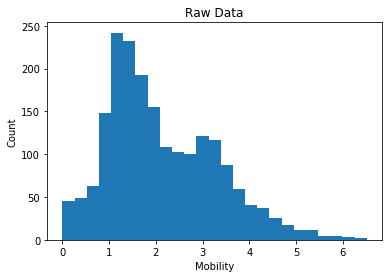

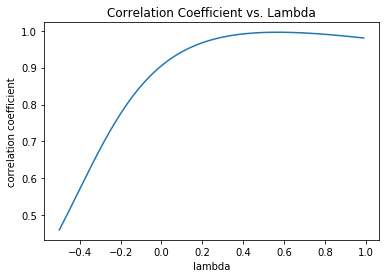

Value of Lambda which maximized the correlation coefficient: 0.570000


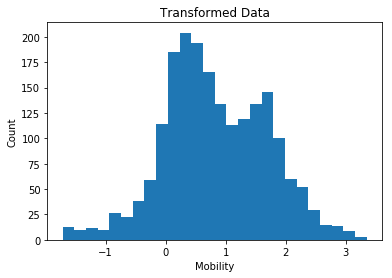

Transform mode is 0.328137
Transform mean is 0.834768
Transform median is 0.737990
Normal mode is 1.350952
Normal mean is 1.979469
Normal median is 1.851500


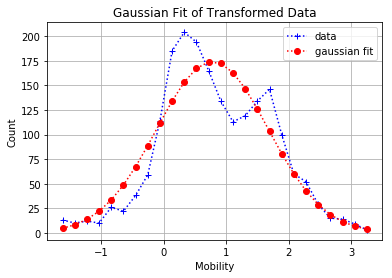

0.718309079239722
1.825926041487317


In [52]:
applyBoxCoxTransform(resistanceList)

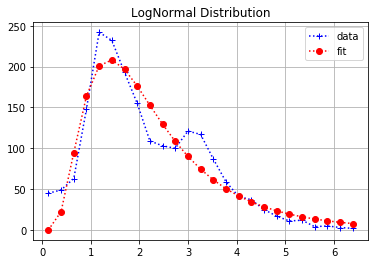

Mean is: 2.361349
Median is: 1.975409
Mode is: 1.382454
Variance is: 2.391616
Skewness is: 2.245651
mu is: 0.680775
Sigma is: 0.597424
BIC is: 166.426384


In [53]:
lognormalDistFit(resistanceList)

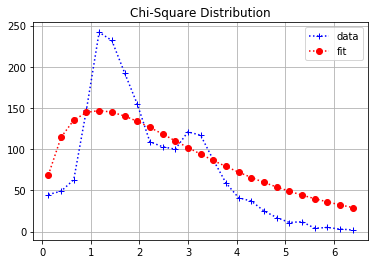

BIC is: 192.439313


In [54]:
chiSquareDistFit(resistanceList)

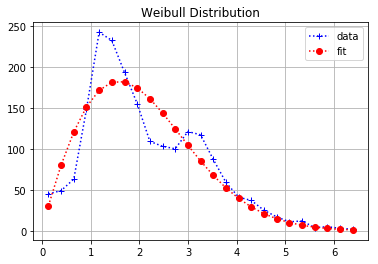

Mean is: 2.066859
Median is: 1.922539
Mode is: 1.579042
Variance is: 1.269855
Skewness is: 0.694899
Lambda is: 2.329546
k is: 1.908653
BIC is: 175.994083


In [55]:
weibullFit(resistanceList)

Mean is: 2.152075
Mode is: 1.477510
Variance is: 1.451714
Skewness is: 1.119729
g is: 3.190316
beta is: 0.674565


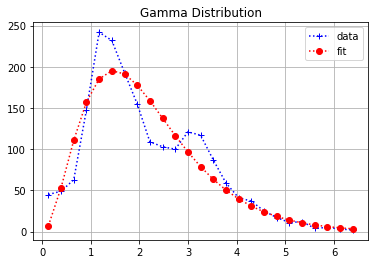

BIC is: 170.640445


In [56]:
gammaDistFit(resistanceList)

Mean is: 2.183832
Mode is: 1.455888
Variance is: 1.589708
Skewness is: 1.154701
k is: 3
lambda is: 1.373732


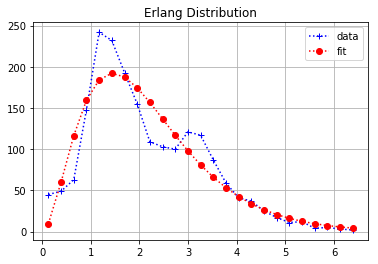

BIC is: 170.918220


In [57]:
erlangDistFit(resistanceList)

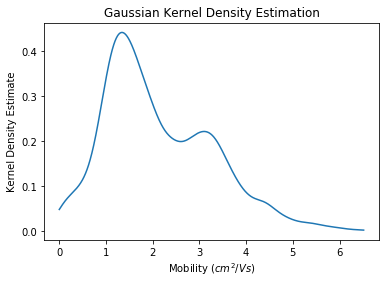

1.1697746730592173
2.1440448517922754
1.1739930971567034
2.127314892925271
Mode is: 1.344521 $cm^{2}/Vs$
Mean is: 2.127315 +- 1.169775


In [58]:
kernelDensityEstimate(resistanceList)